In [15]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import csv
import datetime

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>")) #ez hogy a rákban nem a defaultja a jupyternek?

In [20]:
def createNxGraph(filename):
    """
    G = nx.Graph()
    with open(filename, 'r') as inputfile:
        csvr = csv.reader(inputfile, delimiter=',')
        next(csvr) # we don't want to read the header, so we skip it
        for line in csvr:
            # we add an edge between the ID of the proposition
            # and the ID of the MEP
            amendment = (line[0],datetime.datetime.strptime(line[3], "%d/%m/%Y"))
            mep = (line[6],line[7],line[8],line[9],line[10])
            G.add_node(amendment, bipartite = 0)
            G.add_node(mep, bipartite = 1)
            G.add_edge(amendment, mep)
    return G
    """
    # we put `keep_default_na` here so that nan-s get parsed in the way we want
    df = pd.read_csv(filename, header = 0, keep_default_na = False)
    G = nx.from_pandas_edgelist(df, source='AmendmentID', target='OfficialMEPID')
    return G

def listMEPs(filename):
    """
    L = []
    with open(filename, 'r') as inputfile:
        csvr = csv.reader(inputfile, delimiter=',')
        next(csvr) # we don't want to read the header, so we skip it
        for line in csvr:
            mep = (line[6],line[7],line[8],line[9],line[10])
            L.append(mep)
    return L
    """
    df = pd.read_csv(filename, header = 0, keep_default_na = False)
    o = pd.unique(df["OfficialMEPID"])
    print(type(o))
    return o

In [21]:
print(createNxGraph("db/ep_cosponsorship_dataset.csv"))

Graph with 259357 nodes and 750578 edges


In [22]:
print(listMEPs("db/ep_cosponsorship_dataset.csv"))

<class 'numpy.ndarray'>
['124704' '197572' '94649' '96725' '197770' '113892' '96711' '37324'
 '197721' '197719' '125042' '197718' '197935' '197530' '125064' '197593'
 '96867' '96810' '124785' '188636' '125706' '197767' '23788' '197538'
 '96713' '24922' '124708' '197444' '183916' '128483' '197463' '197788'
 '197799' '197597' '124831' '197806' '124780' '197482' '197826' '197547'
 '197504' '191693' '197512' '124862' '197848' '125045' '197556' '124738'
 '197629' '183793' '97198' '197621' '125012' '197647' '124802' '197824'
 '96772' '197427' '197422' '124808' '24594' '28115' '197773' '96891'
 '124846' '28389' '197518' '197846' '197651' '189525' '197434' '197743'
 '125023' '1917' '88715' '132191' '197533' '197822' '190518' '197787'
 '125046' '197697' '96730' '197554' '197700' '197577' '118949' '197815'
 '197437' '2187' '124693' '197531' '124835' '197616' '197825' '221463'
 '28400' '189065' '197505' '197585' '192634' '197808' '124586' '124734'
 '2309' '96951' '197501' '197655' '22858' '197494

In [23]:
myGraph = createNxGraph("db/ep_cosponsorship_dataset.csv")
list_meps = listMEPs("db/ep_cosponsorship_dataset.csv")

<class 'numpy.ndarray'>


In [24]:
print(f"Some information about this graph:\n"
        f"Number of nodes: {nx.number_of_nodes(myGraph)}\n"
        f"Number of edges: {nx.number_of_edges(myGraph)}\n")

print(f"The nodes in this graph include: {list(myGraph.nodes)[:100]}")

# now amendments are 'int's and MEPS are 'string's.

Some information about this graph:
Number of nodes: 259357
Number of edges: 750578

The nodes in this graph include: [892323, '124704', 880086, '197572', 885326, '94649', 891589, '96725', 881777, '197770', 888406, '113892', 890457, '96711', 894926, 893171, 892450, 894881, 893914, 893108, '37324', 894291, 883936, '197721', '197719', '125042', '197718', 889291, 885412, 884461, 879904, 890644, 879857, '197935', 885362, 891635, '197530', 880857, '125064', 888150, '197593', 886342, 887149, 888086, '96867', 893879, '96810', 893221, '124785', 887654, '188636', 894783, '125706', 881778, 884421, 893372, '197767', '23788', '197538', '96713', 893286, 884484, 880531, 886091, 885447, 888054, 881629, 886288, '24922', 882597, 884341, 891348, 879855, '124708', '197444', 884436, 893420, 879923, 888314, 893432, '183916', 881668, 893827, '128483', 892452, 885460, 889480, '197463', 880572, '197788', '197799', '197597', '124831', '197806', '124780', '197482', 894188, 892355, 881707, 894626]


In [25]:
nx.is_bipartite(myGraph)

True

In [26]:
# most már lefut elég gyorsan !
mep_social_network = nx.algorithms.bipartite.projected_graph(myGraph, list_meps)

In [27]:
deg_hist = nx.degree_histogram(myGraph)
deg_hist


[0,
 134299,
 32769,
 20866,
 16829,
 13583,
 9798,
 8115,
 5789,
 4525,
 3260,
 2349,
 1982,
 1370,
 780,
 829,
 461,
 359,
 182,
 130,
 85,
 52,
 71,
 55,
 84,
 5,
 4,
 0,
 7,
 1,
 0,
 1,
 0,
 2,
 1,
 0,
 1,
 2,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 2,
 0,
 2,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 2,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 2,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 2,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 2,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 2,
 2,
 1,
 1,
 1,
 1

In [28]:
degs = dict(myGraph.degree())

sorted_nodes = sorted(degs.items(), key=lambda x: x[1], reverse=True)
sorted_nodes[:10]

[('197463', 5155),
 ('197702', 4483),
 ('202073', 4350),
 ('197635', 4245),
 ('124785', 4200),
 ('58766', 3914),
 ('197446', 3650),
 ('134605', 3544),
 ('197732', 3533),
 ('197663', 3491)]

Akkor I guess ezek a legaktívabb EP képviselők. Jár nekik a keksz.

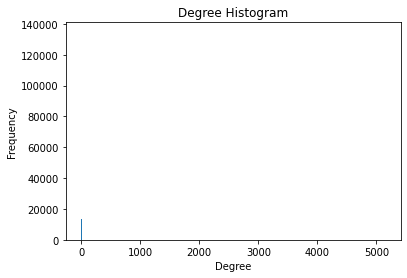

In [18]:
plt.bar(range(len(deg_hist)), deg_hist, align='center')
plt.title("Degree Histogram")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.show()

In [22]:
### melyik ország politikusai csináltak többet?

contribs_by_country = {}

for node in myGraph.nodes():
    if len(node) == 5: # ez egy nagyon maszek módja hogy csak az emberkéket nézzük
        if node[2] not in contribs_by_country:
            contribs_by_country[node[2]] = 0
        #print(node)
        contribs_by_country[node[2]] += myGraph.degree(node)

{'Czechia': 18261,
 'Poland': 33149,
 'France': 87995,
 'Netherlands': 30848,
 'Slovakia': 23123,
 'Romania': 47962,
 'Spain': 85421,
 'Croatia': 8070,
 'Greece': 16068,
 'Portugal': 35618,
 'Italy': 66020,
 'United Kingdom': 760,
 'Belgium': 23610,
 'Germany': 86985,
 'Finland': 17866,
 'Bulgaria': 20478,
 'Ireland': 15049,
 'Hungary': 15526,
 'Sweden': 23242,
 'Malta': 7708,
 'Austria': 18803,
 'Slovenia': 12325,
 'Latvia': 5124,
 'Cyprus': 4314,
 'Luxembourg': 8978,
 'Lithuania': 9253,
 'Estonia': 6625,
 'Denmark': 18785,
 '': 2612}

Az üres string ország politikusai nem tudom mit reprezentálnak.

In [36]:
### melyik évben mennyit dolgoztak?


contribs_by_year = {}

for node in myGraph.nodes():
    if len(node) == 2: # ez egy nagyon maszek módja hogy csak az amendmenteket nézzük
        if node[1].year not in contribs_by_year:
            contribs_by_year[node[1].year] = 0
        #print(node)
        #contribs_by_year[node[1].year] += myGraph.degree(node)
        contribs_by_year[node[1].year] += 1
        
contribs_by_year

{2019: 7258, 2020: 81207, 2021: 92345, 2022: 77793}

Nem igazán látszik se a COVID se az ukrajnai háború hatása a kontribúciók számában.

## MEP_SOCIAL_NETWORK

In [29]:
mep_social_network

In [30]:
print(f"Some information about this graph:\n"
        f"Number of nodes: {nx.number_of_nodes(mep_social_network)}\n"
        f"Number of edges: {nx.number_of_edges(mep_social_network)}\n")

Some information about this graph:
Number of nodes: 754
Number of edges: 21576

